<a href="https://colab.research.google.com/github/rajvirvyas/A-Star_Visualizer/blob/main/SQL_injection_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGLE_USR"] = userdata.get('KAGGLE_USR')

In [2]:
!kaggle datasets download -d sajid576/sql-injection-dataset

Dataset URL: https://www.kaggle.com/datasets/sajid576/sql-injection-dataset
License(s): unknown
  0% 0.00/425k [00:00<?, ?B/s]
100% 425k/425k [00:00<00:00, 41.2MB/s]


In [3]:
! unzip "sql-injection-dataset.zip"

Archive:  sql-injection-dataset.zip
  inflating: Modified_SQL_Dataset.csv  


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv("/content/Modified_SQL_Dataset.csv")

print(df.size)
df

61838


,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0


I can clean up the query column strings to be all lowercase, and with specific preprocessing for sql commands (i.e. which characters to keep and which to remove)

In [16]:
import re

def preprocess(query):
  query = query.lower()
  query = re.sub(r'[^a-z0-9\s=;"]', ' ', query)  # want to keep alphanumeric, spaces, =, and ; for sql
  query = re.sub(r'--', ' -- ', query)  # want to keep sql comment notation
  query = re.sub(r'\s+', ' ', query)
  return query

df["Query"] = df["Query"].apply(preprocess)
#df["Query"].dropna
df

,Query,Label
0,""" or pg sleep time",1
1,create user name identified by pass123 tempora...,1
2,and 1 = utl inaddr get host address select di...,1
3,select from users where id = 1 or 1 = 1 union...,1
4,"select from users where id = 1 or 1 "" union s...",1
...,...,...
30914,delete from door where grow = small,0
30915,delete from tomorrow,0
30916,select wide s from west,0
30917,select from select slide from breath,0


Apply TF-IDF Vectorization to find relevance of words in the queries

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


X = df["Query"]
y = df["Label"]
# vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')


# X = vectorizer.fit_transform(df['Query'])
# y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf)

  (0, 9340)	0.6652094170629653
  (0, 12077)	0.1451972185654535
  (0, 12853)	0.6610338721528065
  (0, 10275)	0.28926011951011754
  (0, 18002)	0.1256065376454009
  (1, 18297)	0.17905791915509495
  (1, 8265)	0.10924210443407731
  (1, 2990)	0.8684117988917519
  (1, 20241)	0.09591056622863685
  (1, 11567)	0.43420589944587595
  (1, 18002)	0.06427886063359502
  (2, 18177)	0.4996076983142266
  (2, 18702)	0.31742259387122507
  (2, 14867)	0.5330232162137036
  (2, 18912)	0.4853245565448069
  (2, 8581)	0.28721290968643076
  (2, 12077)	0.10905084370182254
  (2, 18002)	0.18867439803636457
  (3, 7608)	1.0
  (4, 9685)	1.0
  (5, 11767)	0.5773494398640029
  (5, 9309)	0.5592368361545721
  (5, 8768)	0.5517271220231517
  (5, 20241)	0.15544489871749986
  (5, 12077)	0.12042710381128213
  :	:
  (24730, 613)	1.0
  (24731, 18892)	0.5098179969081091
  (24731, 14817)	0.5098179969081091
  (24731, 13616)	0.4899853161357013
  (24731, 10542)	0.4899853161357013
  (24732, 20162)	0.5973925007799288
  (24732, 10242)	0.57

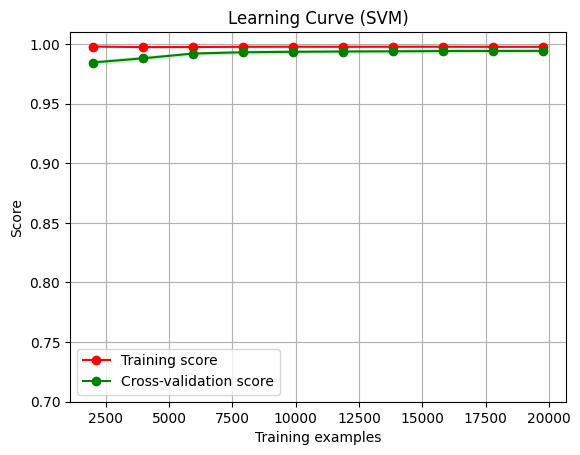

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Calculate the mean and standard deviation for the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Learning Curve (SVM)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim((0.7, 1.01))
plt.grid()

# Plot the average training and testing scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf, y_train)

predictions = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions)
precision= precision_score(y_test, predictions)
recall = recall_score(y_test,predictions)
f1= f1_score(y_test, predictions)

print("----------------Logistic Regression------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("-----------------------------------------------------------")


----------------Logistic Regression------------------------
Accuracy: 0.9723479948253557
Precision: 0.9834634818557648
Recall: 0.9406854130052724
F1: 0.9615989220750056
-----------------------------------------------------------


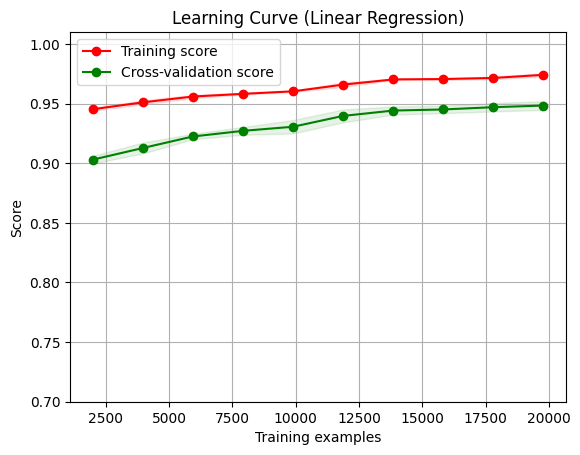

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train_tfidf, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Calculate the mean and standard deviation for the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Learning Curve (Linear Regression)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim((0.7, 1.01))
plt.grid()

# Plot the average training and testing scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier()
model2.fit(X_train_tfidf, y_train)

predictions2= model2.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions2)
precision= precision_score(y_test, predictions2)
recall = recall_score(y_test,predictions2)
f1= f1_score(y_test, predictions2)

print("----------------Decision Tree------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("-----------------------------------------------------------")

----------------Decision Tree------------------------
Accuracy: 0.8067593790426908
Precision: 0.6614878996115925
Recall: 0.9727592267135325
F1: 0.7874799928863597
-----------------------------------------------------------


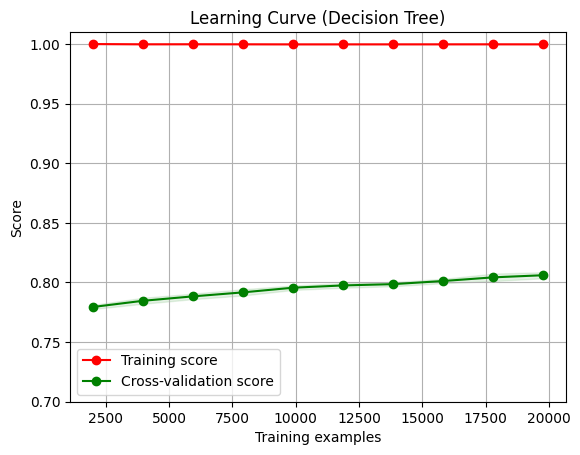

In [22]:
# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(model2, X_train_tfidf, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Calculate the mean and standard deviation for the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Learning Curve (Decision Tree)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim((0.7, 1.01))
plt.grid()

# Plot the average training and testing scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

In [13]:
from sklearn.linear_model import Perceptron

model3 = Perceptron(random_state=42)
model3.fit(X_train_tfidf, y_train)

predictions3 = model3.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions3)
precision= precision_score(y_test, predictions3)
recall = recall_score(y_test,predictions3)
f1= f1_score(y_test, predictions3)

print("----------------Perceptron------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("-----------------------------------------------------------")

----------------Perceptron------------------------
Accuracy: 0.9922380336351876
Precision: 0.9916151809355693
Recall: 0.9872583479789103
F1: 0.9894319682959049
-----------------------------------------------------------


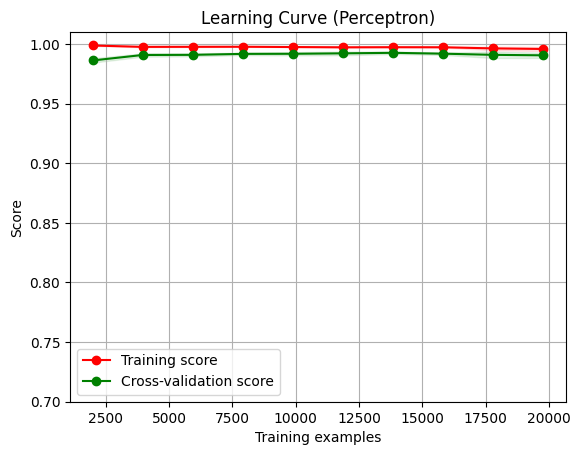

In [23]:
# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(model3, X_train_tfidf, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Calculate the mean and standard deviation for the training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Learning Curve (Perceptron)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.ylim((0.7, 1.01))
plt.grid()

# Plot the average training and testing scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()